In [2]:
import numpy as np
import scanpy as sc
import anndata
import scvi
from scib_metrics.benchmark import Benchmarker
%matplotlib inline
import torch

/local/data/scvi-tools/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/local/data/scvi-tools/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
/local/data/anaconda3/envs/BT/lib/python3.11/site-packages/numba/np/ufunc/dufunc.py:84: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  dispatcher = jit(_target='npyufunc',
/local/data/anaconda3/envs/BT/lib/python3.11/site-pac

In [34]:
adata = sc.read(
    "data/lung_atlas.h5ad",
    backup_url="https://figshare.com/ndownloader/files/24539942",
)

In [35]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000, flavor="cell_ranger", batch_key="batch")
sc.tl.pca(adata, n_comps=30, use_highly_variable=True)

In [36]:
adata = adata[:, adata.var.highly_variable].copy()

In [37]:
adata.obsm["Unintegrated"] = adata.obsm["X_pca"]

In [38]:
%%capture
import scanorama

# List of adata per batch
batch_cats = adata.obs.batch.cat.categories
adata_list = [adata[adata.obs.batch == b].copy() for b in batch_cats]
scanorama.integrate_scanpy(adata_list)

adata.obsm["Scanorama"] = np.zeros((adata.shape[0], adata_list[0].obsm["X_scanorama"].shape[1]))
for i, b in enumerate(batch_cats):
    adata.obsm["Scanorama"][adata.obs.batch == b] = adata_list[i].obsm["X_scanorama"]

In [39]:
import pyliger

bdata = adata.copy()
# Pyliger normalizes by library size with a size factor of 1
# So here we give it the count data
bdata.X = bdata.layers["counts"]
# List of adata per batch
adata_list = [bdata[bdata.obs.batch == b].copy() for b in batch_cats]
for i, ad in enumerate(adata_list):
    ad.uns["sample_name"] = batch_cats[i]
    # Hack to make sure each method uses the same genes
    ad.uns["var_gene_idx"] = np.arange(bdata.n_vars)


liger_data = pyliger.create_liger(adata_list, remove_missing=False, make_sparse=False)
# Hack to make sure each method uses the same genes
liger_data.var_genes = bdata.var_names
pyliger.normalize(liger_data)
pyliger.scale_not_center(liger_data)
pyliger.optimize_ALS(liger_data, k=30)
pyliger.quantile_norm(liger_data)


adata.obsm["LIGER"] = np.zeros((adata.shape[0], liger_data.adata_list[0].obsm["H_norm"].shape[1]))
for i, b in enumerate(batch_cats):
    adata.obsm["LIGER"][adata.obs.batch == b] = liger_data.adata_list[i].obsm["H_norm"]

/local/data/anaconda3/envs/BT/lib/python3.11/site-packages/pyliger/preprocessing/_scale.py:88: RuntimeWarning: divide by zero encountered in divide
100%|██████████| 30/30 [10:19<00:00, 20.65s/it]


In [40]:
adata.write_h5ad(filename="data/adataw.h5ad")

In [4]:
adata = anndata.read_h5ad(filename="data/adataw.h5ad")

In [3]:
def trainModel(adata, prior, prior_kwargs = None, max_epochs = 100):
    scvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key="batch")
    vae = scvi.model.SCVI(adata, prior_distribution = prior,prior_kwargs=prior_kwargs, n_layers=2, n_latent=30)
    vae.train(max_epochs=max_epochs,check_val_every_n_epoch=5)
    adata.obsm["scVI"] = vae.get_latent_representation()
    return adata, vae

def plotBenchmarkResults(adata,keys=None):
    if keys == None:
        bm = Benchmarker(
        adata,
        batch_key="batch",
        label_key="cell_type",
        embedding_obsm_keys=["Unintegrated", "LIGER", "Scanorama", "scVI"],
        n_jobs=6,
        )
    else:
        bm = Benchmarker(
        adata,
        batch_key="batch",
        label_key="cell_type",
        embedding_obsm_keys=keys,
        n_jobs=6,
        )
    bm.benchmark()
    bm.plot_results_table(min_max_scale=False)

In [65]:
sdnormalAdata, vaeSD = trainModel(anndata.read_h5ad(filename="data/adataw.h5ad"), "sdnormal",max_epochs=100)

/local/data/scvi-tools/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1/100:   0%|          | 0/100 [00:00<?, ?it/s]

/local/data/scvi-tools/scvi/module/_vae.py:519: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/local/data/scvi-tools/scvi/module/_vae.py:519: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 2/100:   1%|          | 1/100 [00:01<02:55,  1.77s/it, v_num=1, train_loss_step=555, train_loss_epoch=664]

/local/data/scvi-tools/scvi/module/_vae.py:519: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 6/100:   5%|▌         | 5/100 [00:09<02:55,  1.84s/it, v_num=1, train_loss_step=543, train_loss_epoch=560]

/local/data/scvi-tools/scvi/module/_vae.py:519: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 100/100: 100%|██████████| 100/100 [02:52<00:00,  1.67s/it, v_num=1, train_loss_step=527, train_loss_epoch=514]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|██████████| 100/100 [02:52<00:00,  1.73s/it, v_num=1, train_loss_step=527, train_loss_epoch=514]


Computing neighbors:   0%|          | 0/4 [00:00<?, ?it/s]/local/data/anaconda3/envs/BT/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/local/data/anaconda3/envs/BT/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/local/data/anaconda3/

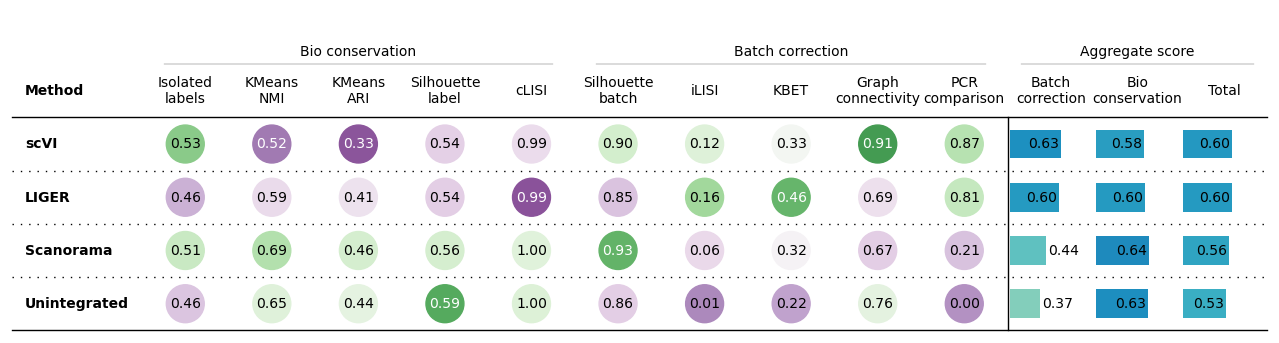

In [5]:
plotBenchmarkResults(sdnormalAdata)

In [13]:
normalAdata = trainModel(anndata.read_h5ad(filename="data/adataw.h5ad"), "normal",max_epochs=200)

/local/data/scvi-tools/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1/200:   0%|          | 0/200 [00:00<?, ?it/s]

/local/data/scvi-tools/scvi/module/_vae.py:519: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/local/data/scvi-tools/scvi/module/_vae.py:519: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 2/200:   0%|          | 1/200 [00:01<05:43,  1.72s/it, v_num=1, train_loss_step=571, train_loss_epoch=660]

/local/data/scvi-tools/scvi/module/_vae.py:519: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 200/200: 100%|██████████| 200/200 [05:26<00:00,  1.64s/it, v_num=1, train_loss_step=529, train_loss_epoch=517]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [05:26<00:00,  1.63s/it, v_num=1, train_loss_step=529, train_loss_epoch=517]


In [15]:
mogAdata = trainModel(anndata.read_h5ad(filename="data/adataw.h5ad"), "mixofgaus",max_epochs=200)

/local/data/scvi-tools/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1/200:   0%|          | 0/200 [00:00<?, ?it/s]

/local/data/scvi-tools/scvi/module/_vae.py:519: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/local/data/scvi-tools/scvi/module/_vae.py:519: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 2/200:   0%|          | 1/200 [00:01<06:26,  1.94s/it, v_num=1, train_loss_step=558, train_loss_epoch=662]

/local/data/scvi-tools/scvi/module/_vae.py:519: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 200/200: 100%|██████████| 200/200 [06:21<00:00,  1.92s/it, v_num=1, train_loss_step=539, train_loss_epoch=517]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [06:21<00:00,  1.91s/it, v_num=1, train_loss_step=539, train_loss_epoch=517]


Embeddings:   0%|          | 0/4 [00:00<?, ?it/s]/local/data/anaconda3/envs/BT/lib/python3.11/site-packages/scib_metrics/_pcr_comparison.py:49: UserWarning: PCR comparison score is negative, meaning variance contribution increased after integration. Setting to 0.
  warnings.warn(
Embeddings: 100%|██████████| 4/4 [03:28<00:00, 52.03s/it]


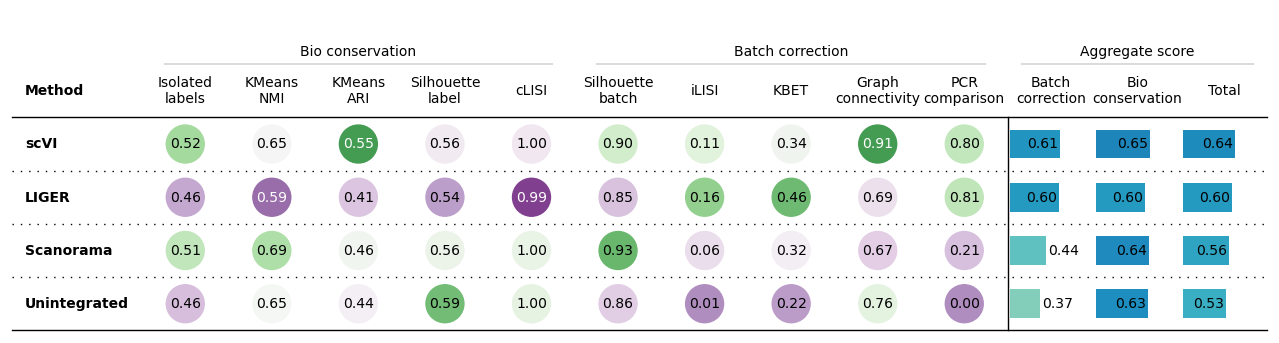

In [10]:
plotBenchmarkResults(mogAdata)

In [23]:
vampAdata = trainModel(anndata.read_h5ad(filename="data/adataw.h5ad"), "vamp",max_epochs=100)

/local/data/scvi-tools/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1/100:   0%|          | 0/100 [00:00<?, ?it/s]

/local/data/scvi-tools/scvi/module/_vae.py:519: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/local/data/scvi-tools/scvi/module/_vae.py:519: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 2/100:   1%|          | 1/100 [00:02<03:45,  2.28s/it, v_num=1, train_loss_step=556, train_loss_epoch=660]

/local/data/scvi-tools/scvi/module/_vae.py:519: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 100/100: 100%|██████████| 100/100 [03:35<00:00,  2.16s/it, v_num=1, train_loss_step=483, train_loss_epoch=513]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|██████████| 100/100 [03:35<00:00,  2.15s/it, v_num=1, train_loss_step=483, train_loss_epoch=513]


In [14]:
adataAll = normalAdata

In [18]:
adataAll.obsm["scVISDNormal"] = sdnormalAdata.obsm["scVI"]
adataAll.obsm["scVINormal"] = normalAdata.obsm["scVI"]
adataAll.obsm["scVIMoG"] = mogAdata.obsm["scVI"]
adataAll.obsm["scVIVamp"] = vampAdata.obsm["scVI"]

In [19]:
adataAll.write_h5ad(filename="data/adataAll.h5ad")

In [20]:
adataAll = anndata.read_h5ad(filename="data/adataAll.h5ad")

In [11]:
adataAll

AnnData object with n_obs × n_vars = 32472 × 2000
    obs: 'dataset', 'location', 'nGene', 'nUMI', 'patientGroup', 'percent.mito', 'protocol', 'sanger_type', 'size_factors', 'sampling_method', 'batch', 'cell_type', 'donor', '_scvi_batch', '_scvi_labels'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'hvg', 'pca'
    obsm: 'LIGER', 'Scanorama', 'Unintegrated', 'X_pca', 'scVI', 'scVIMoG', 'scVINormal', 'scVISDNormal'
    varm: 'PCs'
    layers: 'counts'

Embeddings:   0%|          | 0/7 [00:00<?, ?it/s]/local/data/anaconda3/envs/BT/lib/python3.11/site-packages/scib_metrics/_pcr_comparison.py:49: UserWarning: PCR comparison score is negative, meaning variance contribution increased after integration. Setting to 0.
  warnings.warn(
Embeddings: 100%|██████████| 7/7 [04:16<00:00, 36.69s/it]


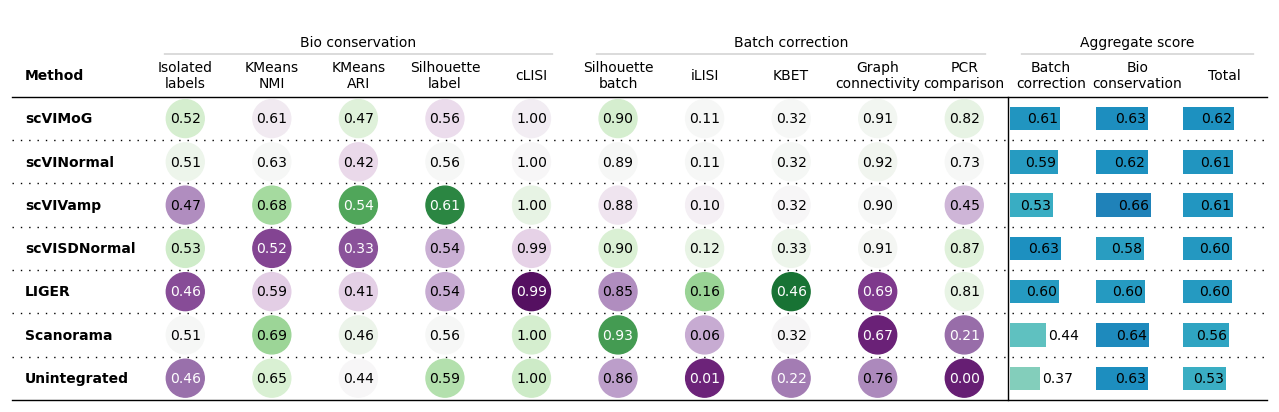

In [21]:
plotBenchmarkResults(adataAll,["Unintegrated", "LIGER", "Scanorama", "scVINormal","scVIMoG","scVIVamp","scVISDNormal"])

In [34]:
adataSD, vaeSD = trainModel(adata, "sdnormal")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1/100:   0%|          | 0/100 [00:00<?, ?it/s]

/local/data/scvi-tools/scvi/module/_vae.py:519: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/local/data/scvi-tools/scvi/module/_vae.py:519: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 2/100:   1%|          | 1/100 [00:01<02:57,  1.79s/it, v_num=1, train_loss_step=590, train_loss_epoch=661]

/local/data/scvi-tools/scvi/module/_vae.py:519: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 6/100:   5%|▌         | 5/100 [00:08<02:51,  1.80s/it, v_num=1, train_loss_step=580, train_loss_epoch=561]

/local/data/scvi-tools/scvi/module/_vae.py:519: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 100/100: 100%|██████████| 100/100 [02:59<00:00,  1.76s/it, v_num=1, train_loss_step=516, train_loss_epoch=514]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|██████████| 100/100 [02:59<00:00,  1.80s/it, v_num=1, train_loss_step=516, train_loss_epoch=514]


In [5]:
adataVP, vaeVP = trainModel(adata, "vamp")

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


/local/data/scvi-tools/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1/100:   0%|          | 0/100 [00:00<?, ?it/s]

/local/data/scvi-tools/scvi/module/_vae.py:519: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/local/data/scvi-tools/scvi/module/_vae.py:519: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 2/100:   1%|          | 1/100 [00:03<06:32,  3.96s/it, v_num=1, train_loss_step=631, train_loss_epoch=664]

/local/data/scvi-tools/scvi/module/_vae.py:519: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 6/100:   5%|▌         | 5/100 [00:12<03:50,  2.42s/it, v_num=1, train_loss_step=514, train_loss_epoch=561]

/local/data/scvi-tools/scvi/module/_vae.py:519: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 100/100: 100%|██████████| 100/100 [03:31<00:00,  2.03s/it, v_num=1, train_loss_step=545, train_loss_epoch=513]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|██████████| 100/100 [03:31<00:00,  2.11s/it, v_num=1, train_loss_step=545, train_loss_epoch=513]


In [76]:
adataMG, vaeMG = trainModel(adata, "mixofgaus",max_epochs=400)

/local/data/scvi-tools/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1/400:   0%|          | 0/400 [00:00<?, ?it/s]

/local/data/scvi-tools/scvi/module/_vae.py:519: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/local/data/scvi-tools/scvi/module/_vae.py:519: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 2/400:   0%|          | 1/400 [00:01<13:14,  1.99s/it, v_num=1, train_loss_step=534, train_loss_epoch=660]

/local/data/scvi-tools/scvi/module/_vae.py:519: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 6/400:   1%|▏         | 5/400 [00:09<13:10,  2.00s/it, v_num=1, train_loss_step=583, train_loss_epoch=560]

/local/data/scvi-tools/scvi/module/_vae.py:519: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 400/400: 100%|██████████| 400/400 [12:57<00:00,  1.95s/it, v_num=1, train_loss_step=598, train_loss_epoch=521]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [12:57<00:00,  1.94s/it, v_num=1, train_loss_step=598, train_loss_epoch=521]


In [73]:
def plotTrainingHistory(model):
    train_elbo = model.history["elbo_train"][1:]
    test_elbo = model.history["elbo_validation"]
    ax = train_elbo.plot()
    test_elbo.plot(ax=ax)

def plotReconstructionLoss(model):
    train_elbo = model.history["reconstruction_loss_train"][1:]
    test_elbo = model.history["reconstruction_loss_validation"]
    ax = train_elbo.plot()
    test_elbo.plot(ax=ax)

def plotKLLocalLoss(model):
    train_elbo = model.history["kl_local_train"][1:]
    test_elbo = model.history["kl_local_validation"]
    ax = train_elbo.plot()
    test_elbo.plot(ax=ax)

def plotKLGlobalLoss(model):
    train_elbo = model.history["kl_global_train"][1:]
    test_elbo = model.history["kl_global_validation"]
    ax = train_elbo.plot()
    test_elbo.plot(ax=ax)

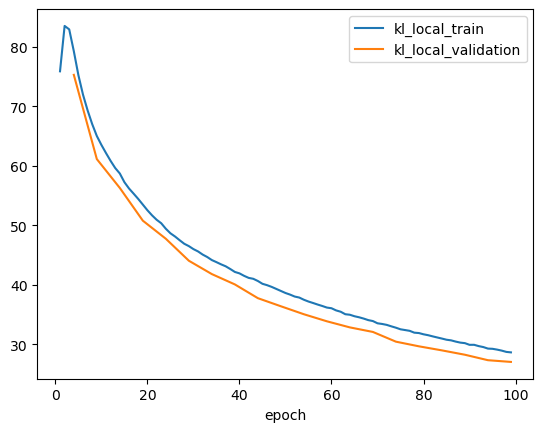

In [80]:
plotKLLocalLoss(vaeSD)

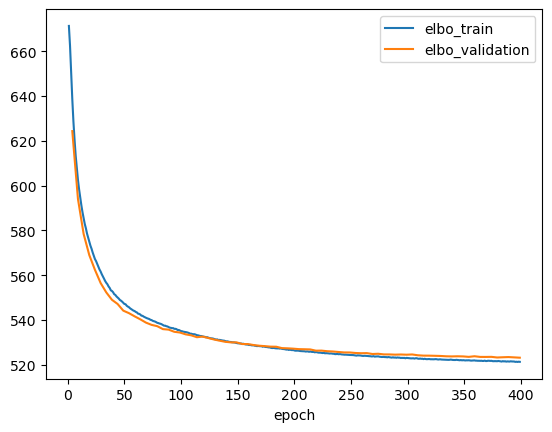

In [77]:
plotTrainingHistory(vaeMG)

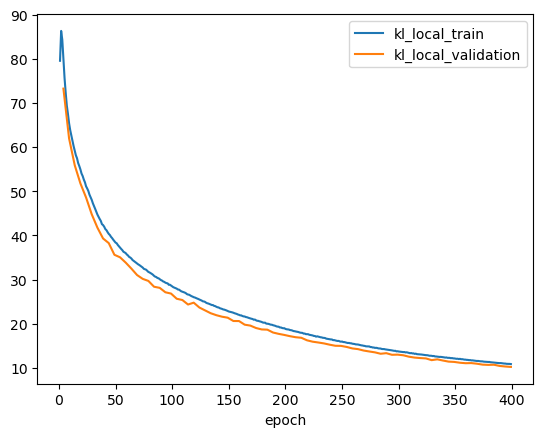

In [78]:
plotKLLocalLoss(vaeMG)

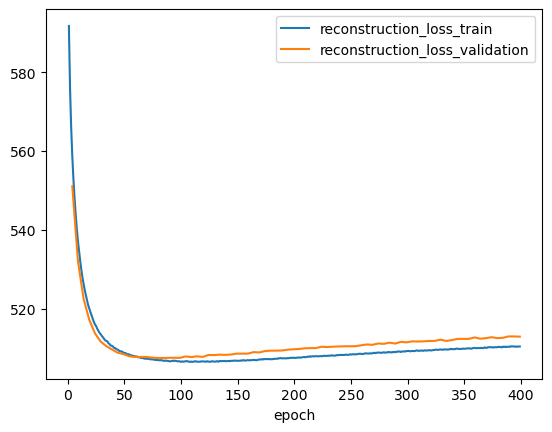

In [79]:
plotReconstructionLoss(vaeMG)

In [12]:
_, (_,enc) = vaeVP.module.prior.get_pseudo_inputs()

In [74]:
enc.shape

torch.Size([200, 30])

In [25]:
np.array(np.transpose(enc.cpu().detach())[0])

array([-2.1052349 , -2.1367128 , -1.6515994 , -2.3507836 , -2.2703564 ,
       -2.5251064 , -1.7042472 , -2.0766017 , -2.497867  , -1.7896899 ,
       -1.7536037 , -1.9517581 , -2.4847872 , -2.3405886 , -2.5407841 ,
       -1.9220324 , -2.328643  , -2.2311468 , -2.8557274 , -1.9543636 ,
       -2.4940546 , -2.3959107 , -1.8535826 , -1.8919461 , -2.5956733 ,
       -2.5916967 , -2.2172275 , -2.595214  , -2.640233  , -2.1103358 ,
       -2.2423768 , -2.113202  , -2.2480512 , -2.367852  , -2.2801893 ,
       -2.2891617 , -2.3869452 , -1.8472946 , -2.0338554 , -2.0366945 ,
       -2.0512125 , -2.0791287 , -1.7019145 , -2.6428363 , -2.2623792 ,
       -2.26933   , -2.5278292 , -0.7920788 , -2.5843542 , -2.226464  ,
       -2.2803707 , -2.338439  , -2.2366717 , -2.4201908 , -2.6763036 ,
       -2.4806173 , -2.521816  , -2.8341367 , -2.8425167 , -1.1649246 ,
       -2.20121   , -2.4155889 , -2.3908043 , -2.6367269 , -1.0128868 ,
       -2.4026566 , -2.575267  , -2.1733027 , -2.5024927 , -2.01

In [61]:
def computeVars(enc):
    vars = []
    for i in range(30):
        vars.append(np.var(np.array(np.transpose(enc.cpu().detach())[i])))
    return vars

In [62]:
computeVars(enc)

[0.21603821,
 0.15723954,
 0.1414962,
 0.18324797,
 0.17594694,
 0.1852549,
 0.18246111,
 0.20832627,
 0.27854216,
 0.25176862,
 0.21832028,
 0.1811787,
 0.15756582,
 0.21352547,
 0.1833537,
 0.18584068,
 0.20169362,
 0.18869099,
 0.20992191,
 0.15378639,
 0.117625386,
 0.18146892,
 0.1768573,
 0.18081631,
 0.16337258,
 0.21875335,
 0.17991741,
 0.19904189,
 0.1704946,
 0.18299206]

In [58]:
_, out = vaeMG.module.z_encoder(torch.eye(2000).cuda(0))

In [66]:
_, out2 = vaeSD.module.z_encoder(torch.eye(2000).cuda(0))

In [63]:
computeVars(out)

[0.60319924,
 0.16616128,
 0.41149107,
 0.33095512,
 0.72372925,
 0.7487056,
 0.3762376,
 0.38814598,
 0.3586352,
 0.29254538,
 0.3335902,
 0.75692505,
 0.31549165,
 0.6599225,
 0.75965863,
 0.71038854,
 0.37609476,
 0.5332439,
 0.81075644,
 0.44556856,
 0.20133762,
 0.62519604,
 0.6797801,
 0.35818776,
 0.7468379,
 0.56681836,
 0.6976528,
 0.16615953,
 0.56073457,
 0.45129943]

In [67]:
computeVars(out2)

[0.8199271,
 0.41707936,
 0.21754776,
 0.3212759,
 0.13280147,
 0.98397523,
 0.17773493,
 0.56953764,
 0.4874422,
 0.49946013,
 1.039157,
 0.2793599,
 0.144185,
 0.7867583,
 0.27282727,
 0.28003663,
 0.3356946,
 0.9473237,
 0.5699111,
 1.0131202,
 1.1707581,
 0.48688242,
 0.47999713,
 0.65277684,
 0.91460997,
 0.80807525,
 1.0398583,
 0.9768159,
 0.18764545,
 0.4189035]

In [69]:
prob, out = vaeMG.module.z_encoder(torch.eye(2000).cuda(0))

In [70]:
log_q_zx = prob.log_prob(out)
log_p_z = vaeMG.module.prior.log_prob(out)
kl_divergence_z = (log_q_zx.sum(-1) - log_p_z)

In [71]:
kl_divergence_z

tensor([10.7447,  6.1054, 10.1583,  ..., 10.4504, 10.7387, 14.4729],
       device='cuda:0', grad_fn=<SubBackward0>)